## Contents
- GPU architectures - Fermi, Kepler, Maxwell
- Memory hirerchy in  CUDA - Shared Memory
- Data transfer - h2d and d2d
- Streaming Architecture 

### GPU memory vs CPU Memory
 - GPU has Smaller memory
 - Higher bandwidth
 - Same memory hirerarchy
 - Programmable shared memory

## Memory heirarchy

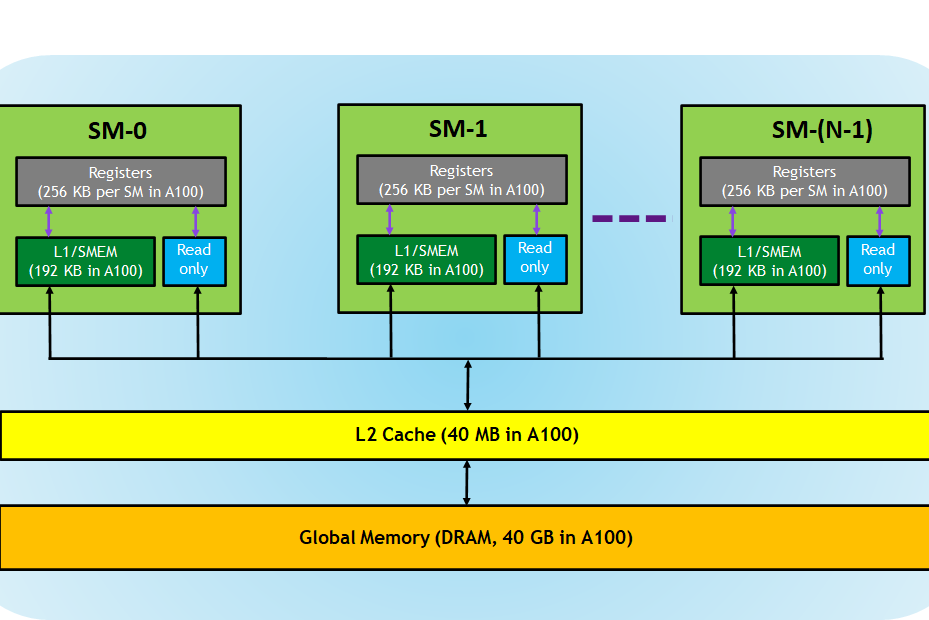

- **Registers**—These are private to each thread, which means that registers assigned to a thread are not visible to other threads. The compiler makes decisions about register utilization.
- **L1/Shared memory (SMEM)** —Every SM has a fast, on-chip scratchpad memory that can be used as L1 cache and shared memory. All threads in a CUDA block can share shared memory, and all CUDA blocks running on a given SM can share the physical memory resource provided by the SM.
- **Read-only memory** —Each SM has an instruction cache, constant memory,  texture memory and RO cache, which is read-only to kernel code.
- **L2 cache** —The L2 cache is shared across all SMs, so every thread in every CUDA block can access this memory. The NVIDIA A100 GPU has increased the L2 cache size to 40 MB as compared to 6 MB in V100 GPUs.
- **Global memory** —This is the frame buffer size of the GPU and DRAM sitting in the GPU.

The NVIDIA CUDA compiler does a good job in optimizing memory resources but an expert CUDA developer can choose to use this memory hierarchy efficiently to optimize the CUDA programs as needed.


### When GPU <---> CPU memory transfers are performed
- The GPU memory is connected to CPU memory with a PCI-Express of 8GB/sec bandwidth.
- The GPU memory has a bandwidth of 200 GB/sec, much greater than CPU memory bandwidth.
- The CPU memory bandwidth is 40 GB/sec.
#### When transfers are performed
- When transferring input/output arrays



## Data transfers in cuda
- Pageable and pinned
- Explicit and implicit (UVM)
- Peer to Peer (between GPUs of the same host)
- GPU direct (between GPU and network interface)
- Synchronous and asynchronous

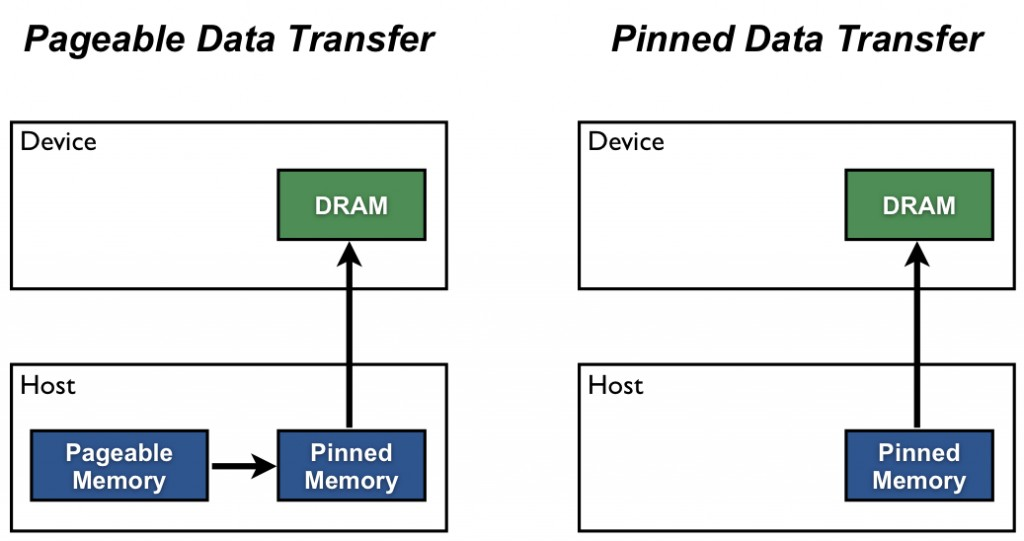


## Kernels and SMs

### Kernels (in software)
- A function that is meant to be executed in parallel on an attached GPU is called a kernel.
- In CUDA, a kernel is usually identified by the presence of the __global__ specifier in front of an otherwise normal-looking C++ function declaration.
- The designation __global__ means the kernel may be called from either the host or the device, but it will execute on the device.
- Accordingly, kernel calls must supply special arguments specifying how many threads to use on the GPU.
- They do this using CUDA's "execution configuration" syntax, which looks like this: fun<<<1, N>>>(x, y, z). Note that the first entry in the configuration (1, in this case) gives the number of blocks of N threads that will be launched.

### Streaming multiprocessors (in hardware)
- On the GPU, a kernel call is executed by one or more streaming multiprocessors or SMs.
- The SMs are the hardware homes of the CUDA cores that execute the threads.
- The CUDA cores in each SM are always arranged in sets of 32 so that the SM can use them to execute full warps of threads.
- The exact number of SMs available in a device depends on its NVIDIA processor family (Volta, Turing, etc.), as well as the specific model number of the processor.
- Thus, the Volta chip in the Tesla V100 has 80 SMs in total, while the more recent Turing chip in the Quadro RTX 5000 has just 48.
- However, the number of SMs that the GPU will actually use to execute a kernel call is limited to the number of thread blocks specified in the call.
- Taking the call fun<<<M, N>>>(x, y, z) as an example, there are at most M blocks that can be assigned to different SMs.
- A thread block may not be split between different SMs. (If there are more blocks than available SMs, then more than one block may be assigned to the same SM.)
- By distributing blocks in this manner, the GPU can run independent blocks of threads in parallel on different SMs.
- Each SM then divides the N threads in its current block into warps of 32 threads for parallel execution internally. On every cycle, each SM's schedulers are responsible for assigning full warps of threads to run on available sets of 32 CUDA cores. (The Volta architecture has 4 such schedulers per SM.)
- Any leftover, partial warps in a thread block will still be assigned to run on a set of 32 CUDA cores.
- The SM includes several levels of memory that can be accessed only by the CUDA cores of that SM: registers, L1 cache, constant caches, and shared memory.


#### Special function units in SM's

- SFUs are specialized units within an SM that efficiently handle specific mathematical operations, such as trigonometric functions (sin, cos, etc.), exponentiation, and reciprocal square roots.
- There are distinct components: FP32 units for handling single-precision floating-point numbers, FP64 units for double-precision,
- Load/Store Units (LD/ST)

#### Tensor Cores

Matrix multiplication is a fundamental operation extensively employed in deep learning. It involves multiplying corresponding elements of rows and columns within matrices and subsequently adding these products together.

- In 2017, Nvidia added their Tensor Cores, a groundbreaking addition to their Streaming Multiprocessors (SMs) as part of the Volta GPU architecture. We know the second part “Core” but what is the Tensor?

- 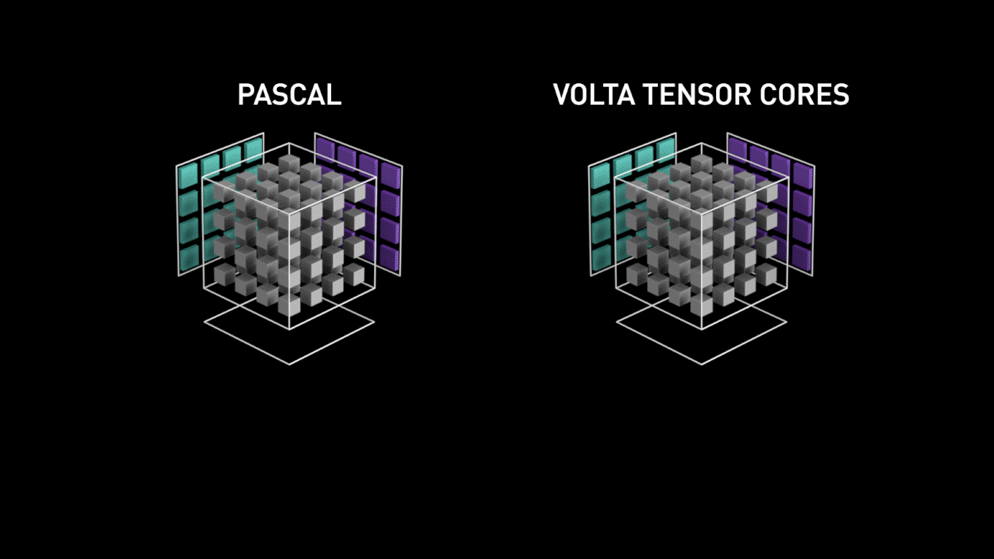

```cpp
#include <stdio.h>
#include <assert.h>

// Convenience function for checking CUDA runtime API results
// can be wrapped around any runtime API call. No-op in release builds.
inline
cudaError_t checkCuda(cudaError_t result)
{
#if defined(DEBUG) || defined(_DEBUG)
  if (result != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime Error: %s\n", cudaGetErrorString(result));
    assert(result == cudaSuccess);
  }
#endif
  return result;
}

void profileCopies(float        *h_a, 
                   float        *h_b, 
                   float        *d, 
                   unsigned int  n,
                   char         *desc)
{
  printf("\n%s transfers\n", desc);

  unsigned int bytes = n * sizeof(float);

  // events for timing
  cudaEvent_t startEvent, stopEvent; 
  
  checkCuda( cudaEventCreate(&startEvent) );
  checkCuda( cudaEventCreate(&stopEvent) );
  
  checkCuda( cudaEventRecord(startEvent, 0) );
  checkCuda( cudaMemcpy(d, h_a, bytes, cudaMemcpyHostToDevice) );
  checkCuda( cudaEventRecord(stopEvent, 0) );
  checkCuda( cudaEventSynchronize(stopEvent) );

  float time;
  checkCuda( cudaEventElapsedTime(&time, startEvent, stopEvent) );
  printf("  Host to Device bandwidth (GB/s): %f\n", bytes * 1e-6 / time);

  checkCuda( cudaEventRecord(startEvent, 0) );
  checkCuda( cudaMemcpy(h_b, d, bytes, cudaMemcpyDeviceToHost) );
  checkCuda( cudaEventRecord(stopEvent, 0) );
  checkCuda( cudaEventSynchronize(stopEvent) );

  checkCuda( cudaEventElapsedTime(&time, startEvent, stopEvent) );
  printf("  Device to Host bandwidth (GB/s): %f\n", bytes * 1e-6 / time);

  for (int i = 0; i < n; ++i) {
    if (h_a[i] != h_b[i]) {
      printf("*** %s transfers failed ***", desc);
      break;
    }
  }

  // clean up events
  checkCuda( cudaEventDestroy(startEvent) );
  checkCuda( cudaEventDestroy(stopEvent) );
}

int main()
{
  unsigned int nElements = 4*1024*1024;
  const unsigned int bytes = nElements * sizeof(float);

  // host arrays
  float *h_aPageable, *h_bPageable;   
  float *h_aPinned, *h_bPinned;

  // device array
  float *d_a;

  // allocate and initialize
  h_aPageable = (float*)malloc(bytes);                    // host pageable
  h_bPageable = (float*)malloc(bytes);                    // host pageable
  checkCuda( cudaMallocHost((void**)&h_aPinned, bytes) ); // host pinned
  checkCuda( cudaMallocHost((void**)&h_bPinned, bytes) ); // host pinned
  checkCuda( cudaMalloc((void**)&d_a, bytes) );           // device

  for (int i = 0; i < nElements; ++i) h_aPageable[i] = i;      
  memcpy(h_aPinned, h_aPageable, bytes);
  memset(h_bPageable, 0, bytes);
  memset(h_bPinned, 0, bytes);

  // output device info and transfer size
  cudaDeviceProp prop;
  checkCuda( cudaGetDeviceProperties(&prop, 0) );

  printf("\nDevice: %s\n", prop.name);
  printf("Transfer size (MB): %d\n", bytes / (1024 * 1024));

  // perform copies and report bandwidth
  profileCopies(h_aPageable, h_bPageable, d_a, nElements, "Pageable");
  profileCopies(h_aPinned, h_bPinned, d_a, nElements, "Pinned");

  printf("\n");

  // cleanup
  cudaFree(d_a);
  cudaFreeHost(h_aPinned);
  cudaFreeHost(h_bPinned);
  free(h_aPageable);
  free(h_bPageable);

  return 0;
}



```
